##  Vector Search for Cymbal Pets

#### Setup (Python)

Import necessary libraries

In [1]:
# Import libraries
!pip install bigframes==1.42.0
from google.cloud import storage
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import io, os, re

Set up variables & create Google Cloud Storage client

**Manual work**
- Create a bucket (US region)

In [2]:
# Set variables
bucket = 'cymbal-pets-demo-adam' # You need your own bucket

PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]
REGION = 'US' # hardcoded throughout
dataset = 'cymbal_pets' # hardcoded throughout

# Create Cloud Storage client
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(bucket)

In [17]:
!gsutil cp -r gs://data-analytics-golden-demo/cymbal-pets-demo/* gs://cymbal-pets-demo-adam/

Copying gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/product_images_embeddings/product_images_embeddings_000000000000.avro [Content-Type=application/octet-stream]...
Copying gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/product_images_sample/product_images_sample_000000000000.avro [Content-Type=application/octet-stream]...
Copying gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/products/products_000000000000.avro [Content-Type=application/octet-stream]...
Copying gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/products_large/products_large_000000000000.avro [Content-Type=application/octet-stream]...
/ [4 files][ 94.9 MiB/ 94.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Cop

In [4]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS cymbal_pets OPTIONS(location = 'us');

Query is running:   0%|          |

""


In [5]:
%%bigquery

-- LOAD the data from public storage account
LOAD DATA OVERWRITE `cymbal_pets.product_images_embeddings`
FROM FILES (format = 'AVRO', enable_logical_types = true, uris = ['gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/product_images_embeddings/*.avro']);

LOAD DATA OVERWRITE `cymbal_pets.product_images_sample`
FROM FILES (format = 'AVRO', enable_logical_types = true, uris = ['gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/product_images_sample/*.avro']);

LOAD DATA OVERWRITE `cymbal_pets.products`
FROM FILES (format = 'AVRO', enable_logical_types = true, uris = ['gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/products/*.avro']);

LOAD DATA OVERWRITE `cymbal_pets.products_large`
FROM FILES (format = 'AVRO', enable_logical_types = true, uris = ['gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/products_large/*.avro']);

LOAD DATA OVERWRITE `cymbal_pets.products_mm`
FROM FILES (format = 'AVRO', enable_logical_types = true, uris = ['gs://data-analytics-golden-demo/cymbal-pets-demo/Data-Export/products_mm/*.avro']);

Query is running:   0%|          |

""


**Manual**
- Create an external connection called us.verteix-ai and grant access to Vertex AI User

In [11]:
%%bigquery
CREATE MODEL IF NOT EXISTS `cymbal_pets.text_embedding`
  REMOTE WITH CONNECTION `us.vertex-ai`
  OPTIONS (endpoint = 'text-embedding-005');

Query is running:   0%|          |

""


Function to render images from GCS using Pandas dataframes

In [12]:
def display_product_images(df):
    """
    Displays product images from a DataFrame in a grid, showing the filename as title.

    Args:
        df (pandas.DataFrame): DataFrame with columns 'product_id', 'uri', 'distance'
    """
    global bucket

    images_per_row = 3
    num_images = len(df)
    rows = (num_images + images_per_row - 1) // images_per_row
    cols = images_per_row

    fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

    # Handle the case where there's only one row, ensuring axs is always a 2D array
    if rows == 1:
        axs = axs.reshape(1, -1)  # Reshape into a 1xN array
    else:
        axs = np.array(axs).reshape(rows, cols)

    i = 0
    for index, row in df.iterrows():
        full_uri = row['uri']

        match = re.search(r"gs://[^/]+/(.+)", full_uri)
        if match:
            image_path = match.group(1)
        else:
            print(f"ERROR: Invalid GCS URI format: {full_uri}")
            continue

        blob = bucket.get_blob(image_path)

        if blob is None:
            print(f"ERROR: Image not found in bucket: {image_path}")
            continue

        try:
            image = Image.open(io.BytesIO(blob.download_as_bytes()))
        except Exception as e:
            print(f"ERROR: Could not open image {image_path}: {e}")
            continue

        col = i % cols
        row_index = i // cols  # Renamed to avoid conflict with DataFrame row
        axs[row_index, col].imshow(image)

        # Extract filename and set as title
        filename = image_path.split('/')[-1]
        axs[row_index, col].set_title(filename, fontsize=10)
        axs[row_index, col].axis('off')

        i += 1

    # Turn off any remaining axes
    for j in range(i, rows * cols):
        axs[j // cols, j % cols].axis('off')

    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

In [13]:
# BigFrames setup:

import bigframes.pandas as bpd
import bigframes
import pandas as pd
bigframes.pandas.options.experiments.ai_operators = True
bigframes.pandas.options.experiments.blob = True
bigframes.pandas.options.compute.ai_ops_confirmation_threshold = 100

bigframes.options.bigquery.project = PROJECT_ID
# Flag to enable the objectref feature
bigframes.options.experiments.blob = True
bigframes.options.display.progress_bar = None
pd.set_option('display.max_colwidth', None)

from bigframes.ml import llm
gemini_model = llm.GeminiTextGenerator(model_name="gemini-2.0-flash")

/usr/local/lib/python3.10/dist-packages/bigframes/_config/experiment_options.py:54: PreviewWarning: AI operators are still under experiments, and are subject to change in
the future.
  warnings.warn(msg, category=bfe.PreviewWarning)
/usr/local/lib/python3.10/dist-packages/bigframes/_config/experiment_options.py:68: PreviewWarning: BigFrames Blob is still under experiments. It may not work and subject
to change in the future.
  warnings.warn(msg, category=bfe.PreviewWarning)
<ipython-input-13-7f7e9943e9d3>:17: ApiDeprecationWarning: gemini-pro and gemini-1.5-X are going to be deprecated. Use gemini-2.0-X (https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.llm.GeminiTextGenerator) instead. 
  gemini_model = llm.GeminiTextGenerator(model_name="gemini-2.0-flash")
/usr/local/lib/python3.10/dist-packages/bigframes/ml/llm.py:1001: UserWarning: Model name 'gemini-2.0-flash' is not supported. We are currently aware
of the following models: gemini-pro, gemini-1.5-pro-pr

### Vector Search

#### Vector Search with **text** embeddings.

Details:
* User input = text string
* Matched against = text string
* Using `text-embedding-005` model

In [14]:
%%bigquery text_matches

SELECT base.product_id, base.product_name, base.brand, base.category, base.description, base.average_rating, base.uri, distance
    FROM
      VECTOR_SEARCH(
        TABLE `cymbal_pets.products`,
        'embedding',
        (
        -- GENERATE AN EMBEDDING AS A SUBQUERY
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL `cymbal_pets.text_embedding`,
            ( SELECT 'puppy toys' AS content)
          )
        ),
        top_k => 3)
ORDER BY distance DESC;

Query is running:   0%|          |

Downloading:   0%|          |

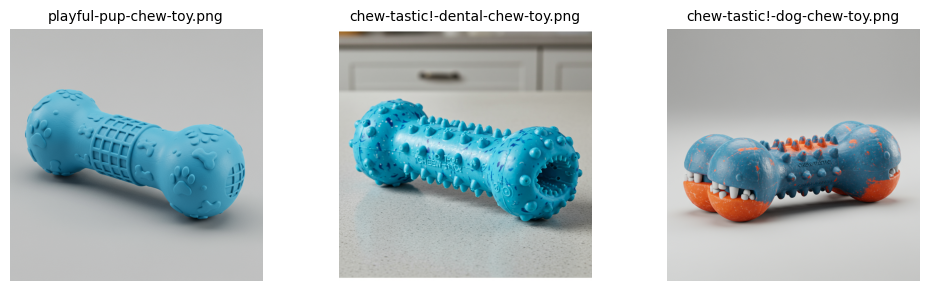

In [18]:
# Display the results
display_product_images(text_matches)

#### Vector Search with **multimodal** embeddings.

Details:
* User input = text string
* Matched against = images in catalog
* Using `multimodalembedding` model

In [21]:
%%bigquery

-- CREATE MULTIMODAL EMBEDDING MODEL
CREATE OR REPLACE MODEL `cymbal_pets.multimodal_embedding`
  REMOTE WITH CONNECTION `us.vertex-ai`
  OPTIONS(ENDPOINT = 'multimodalembedding@001');

Query is running:   0%|          |

""


In [22]:
%%bigquery multimodal_matches

SELECT query.query, base.product_id, base.uri, distance
    FROM
      VECTOR_SEARCH(
        TABLE `cymbal_pets.product_images_embeddings`,
        'embedding',
        (
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL `cymbal_pets.multimodal_embedding`,
            ( SELECT 'fish tank' AS content)
          )
        ),
        top_k => 3)
ORDER BY distance DESC;

Query is running:   0%|          |

Downloading:   0%|          |

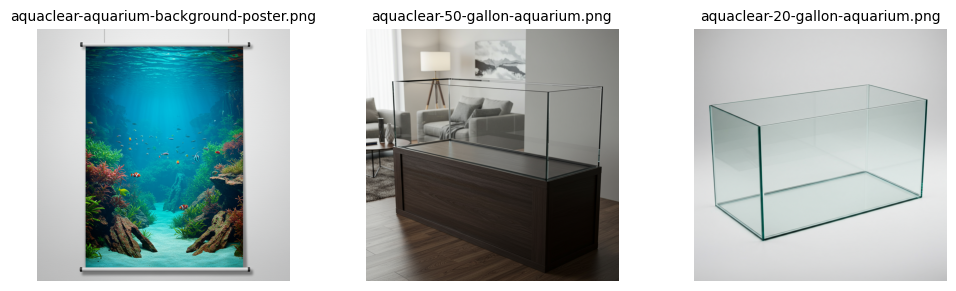

In [23]:
# Display the results
display_product_images(multimodal_matches)

## Check for duplicate products within catalog

In [24]:
%%bigquery df_dup

SELECT base.product_id, base.product_name, base.brand, base.category, base.description, base.average_rating, base.price, base.uri, distance
    FROM
      VECTOR_SEARCH(
        TABLE `cymbal_pets.products`,
        'embedding',
        (
        -- GENERATE AN EMBEDDING AS A SUBQUERY
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL `cymbal_pets.text_embedding`,
            (SELECT 'squeaking fire hydrant dog toy' AS content)
          )
        ),
        top_k => 2)
ORDER BY distance ASC
;

Query is running:   0%|          |

Downloading:   0%|          |

### Check for Duplicates

#### Display the vector search results. Convert into a BigFrames DataFrame

In [25]:
display(df_dup)
#df_dup = bpd.read_pandas(df_dup) #Comment this out to show the images

,product_id,product_name,brand,category,description,average_rating,price,uri,distance
0,824,Perfect Pups Squeaker,Perfect Pups,Toys,"Give your beloved pet a robust and entertaining fire hydrant-shaped toy for countless hours of fun! This durable dog toy helps fulfill their instinctive chewing behaviors, delivering a secure and dependable substitute for real fire hydrants. The solid build ensures continued amusement, making it an ideal addition to your dogs toy collection.",4.1,5.99,gs://cymbal-pets-demo/images/perfect-pups-squeeker.png,0.481229
1,13,Playful Pup Squeaky Toy,Playful Pup,Toys,"This fun fire hydrant lets your furry friend enjoy hours of chewing and playing, satisfying their natural instincts while providing a durable and safe alternative to real hydrants. Its sturdy construction ensures long-lasting entertainment, making it the perfect addition to any playful pup's toy collection.",3.2,7.99,gs://cymbal-pets-demo/images/playful-pup-squeaky-toy.png,0.485195


#### Transform `df_dup` into a multimodal dataframe

In [26]:
# Generate an ObjectRef, move to a multimodal dataframe
df_dup["blob_col"] = df_dup["uri"].str.to_blob()
# Reset index for pivot
df_dup = df_dup.reset_index()
# Pivot df
df_dup["category"] = 0
df_pivot = df_dup.pivot(columns="index", values="blob_col", index="category")

AttributeError: 'StringMethods' object has no attribute 'to_blob'

#### Use Gemini model to check whether the images are identical

In [27]:
# Feed images into Gemini model

result = gemini_model.predict(df_pivot, prompt=["Are these two images identical?", df_pivot[0], df_pivot[1]])

NameError: name 'df_pivot' is not defined

In [28]:
# Display the results

display(result["ml_generate_text_llm_result"])

NameError: name 'result' is not defined

#### Recommend the product that has a lower price

In [29]:
# Choose the duplicate with a lower price

df_dup[df_dup['price'] == df_dup['price'].min()]

,product_id,product_name,brand,category,description,average_rating,price,uri,distance
0,824,Perfect Pups Squeaker,Perfect Pups,Toys,"Give your beloved pet a robust and entertaining fire hydrant-shaped toy for countless hours of fun! This durable dog toy helps fulfill their instinctive chewing behaviors, delivering a secure and dependable substitute for real fire hydrants. The solid build ensures continued amusement, making it an ideal addition to your dogs toy collection.",4.1,5.99,gs://cymbal-pets-demo/images/perfect-pups-squeeker.png,0.481229




---

